In [1]:
# imports
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from einops import rearrange
import matplotlib.pyplot as plt

import random
# hyperparameters
batch_size  = 64
n_channels  = 3
latent_size = 256
dataset = 'ffhq'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cuda device


In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# you may use cifar10 or stl10 datasets
if dataset == 'cifar10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10('drive/My Drive/training/cifar10', train=True, download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
        shuffle=True, batch_size=batch_size, drop_last=True
    )
    class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# stl10 has larger images which are much slower to train on. You should develop your method with CIFAR-10 before experimenting with STL-10
if dataset == 'stl10':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True, transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    train_iterator = iter(cycle(train_loader))
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # these are slightly different to CIFAR-10

if dataset == 'ffhq':
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('images', transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])),
    shuffle=True, batch_size=batch_size, drop_last=True)
    
train_iterator = iter(cycle(train_loader))

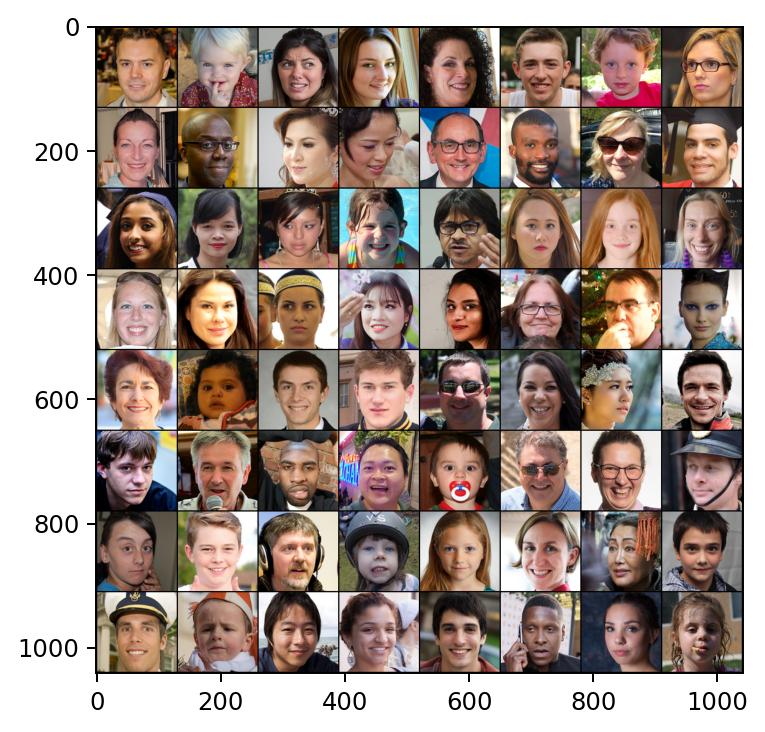

In [3]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 175
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(x).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [4]:
r = torchvision.transforms.functional.get_image_size(x[0])[0]

### Noise Sampling

In [5]:
def generateNoise():
    return torch.randn((batch_size, latent_size, 1, 1), device=device)

### Lightweight Generative Adversarial Network

#### Generator
The generator code is based on the flow diagram from the original paper:<br>
<img src="generator-flow.png"> <br>
The generator model splits into 5 blocks <br>
[1] G_In -> The first block of after the noise generation (Black arrows from input) <br>
[2] G_Upscale -> A block for upscaling in each layer (Blue arrows) <br>
[3] G_SLE -> The skip_layer excitation block <br>
[4] G_Out -> The last block of the model, it outputs images (Black arrow at the last) <br>
[5] Generator -> Final BOSS -> the whole thing, built by [1] - [4], based on the structure of the flow diagram. <br>

In [6]:
#####
##### [1]: The first block of after the noise generation (Black arrows from input)
#####
class G_In(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.In = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c*2, kernel_size=4, stride=1, padding=0), # Leave the output channel the same size as the input one cuz GLU will half it later on
            nn.BatchNorm2d(out_c*2),
            nn.GLU(dim=1),
        )

    def forward(self, x):
        # x is the random noise
        return self.In(x)
#####
##### [2]: A block for upscaling in each layer (Blue arrows)
#####
class G_Upscale(nn.Module):
    # in_c = input channel
    # out_c = output channel
    def __init__(self, in_c, out_c):
        super().__init__()
        self.upscale = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_c, out_c*2, kernel_size=3, stride=1, padding=1), # out_c* 2 -> make sure the output channel has the same size after GLU 
            nn.BatchNorm2d(out_c*2),
            nn.GLU(dim=1),
        )
        
    def forward(self, x):
        return self.upscale(x)
#####
##### [3]: The skip_layer excitation block
#####
class G_SLE(nn.Module):
    # in_c_high = input of the channels of the higher resolution image
    # in_c_low = input of the channels of the lower resolution image
    def __init__(self, in_c_high, in_c_low): 
        super().__init__()
        self.sle = nn.Sequential(
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Conv2d(in_c_low, in_c_low, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_c_low, in_c_high, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x_high, x_low):
        out = x_high * self.sle(x_low)
        return out

#####
##### [4]: The last block of the model, it outputs images (Black arrow at the last)
#####
class G_Out(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.Out = nn.Sequential(
            nn.Conv2d(in_c, n_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.Out(x)

l = latent_size
# index         0 1    2    3       4    5      6    7
# layer         1 4    8    16     32   64     128 -> Layer on the graph
c        =    [l, l, l//2, l//4, l//8, l//16, l//32, 3]
#            256 256  128   64    32 ,  16 ,    8    3 

#####
##### [5] Generator -> the whole generator thing, built by [1] - [4], based on the structure of the flow diagram.
#####
class Generator(nn.Module):
    # in_channels is a list which stores the in channel for each 
    def __init__(self, c):
        super().__init__()
        self.upTo8 = nn.Sequential(
            # get 4 x 4
            G_In(c[0], c[1]),
            # get 8 x 8
            G_Upscale(c[1], c[2]),
        )
        self.gen = nn.ModuleList([
            # get 16 x 16
            G_Upscale(c[2], c[3]),
            # get 32 x 32
            G_Upscale(c[3], c[4]),
            # get 64 x 64
            G_Upscale(c[4], c[5]),
            # get 128 x 128
            G_Upscale(c[5], c[6]),
        ])
        
        self.sles = nn.ModuleList([
            # first sle (8 x 32)
            G_SLE(c[4], c[2]),
            # second sle (16 x 64)
            G_SLE(c[5], c[3]),
        ])
        
        self.last = nn.Sequential(
            G_Out(c[6]),
        )
        
    
    def forward(self, x):
        l_8 = self.upTo8(x)
        l_16 = self.gen[0](l_8)
        l_32 = self.gen[1](l_16)
        l_64 = self.gen[2](self.sles[0](l_32, l_8))
        l_128 = self.gen[3](self.sles[1](l_64, l_16))
        out = self.last(l_128)
        
        return out
        

#### Discriminator
The discriminator code is based on the flow diagram from the original paper:<br>
<img src="discriminator-flow.png"> <br>

The discriminator model splits into 5 blocks <br>
[1] D_In -> The first block to process the real input image (Black right arrows from input images) <br>

[2] D_To16 -> A seqential of block up to Block 16 x 16, it's for resolusion shrinking and channels increasing. Each block inside is linked with [2.1] (Blue arrows to 16) <br>
     *[2.1]* D_Rescale -> Rescaling the resolution and number of channels, it consists of two block, the final output is the elementwise addition of the two blocks. <br>

[3] Decoder_Group -> A sequantial group of 4 decoders, each decoder is defined at [3.1]. (Green block) <br>
    *[3.1]* Decoder -> Decoder to shrink channels back to 3. <br>

[4] D_Logits -> The last block of the model to input Real/fake logits, it outputs numbers <br>

[5] Discriminator -> Final BOSS -> the whole thing, built by [1] - [4], based on the structure of the flow diagram. <br>

In [7]:
#####
##### [1] D_In: The first block to process the real input image (Black right arrows from input images)
#####
# class D_In(nn.Module):
#     def __init__(self, in_c, out_c):
#         super().__init__()
#         self.In = nn.Sequential(
#             nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.1),
#             nn.Conv2d(out_c, out_c, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(out_c),
#             nn.LeakyReLU(0.1),
#         )
        
#     def forward(self, img):
#         return self.In(img)

#####
##### [2] D_To16:  A seqential of block up to Block 16 x 16, it's for resolusion shrinking and channels increasing. 
#####              Each block inside is linked with [2.1] (Blue arrows up to 16)
#####
class D_To16(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.To16 = nn.Sequential(
            # # Get 128
            # D_Rescale(in_c, in_c*2),
            # Get 64
            D_Rescale(in_c, out_c//4),
            # Get 32
            D_Rescale(out_c//4, out_c//2),
            # Get 16
            D_Rescale(out_c//2, out_c),
        )
        
    def forward(self, img):
        return self.To16(img)

#****
#**** [2.1] D_To16: Rescaling the resolution and number of channels. 
#****               It consists of two block, the final output is the elementwise addition of the two blocks.
#****
class D_Rescale(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1),
        )
        self.pool = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.1),
        )
        
    def forward(self, img):
        return self.rescale(img) + self.pool(img)

    
#####
##### [3] Decoder_Group:  A sequantial group of 4 decoders (Green blocks) 
#####                     Each Decoder inside is linked with [3.1] (Blue arrows up to 16)
#####
class Decoder_Group(nn.Module):
    def __init__(self, in_c, out_c):  
        super().__init__()
        self.decoderG = nn.Sequential(
            Decoder(in_c, in_c//2),
            Decoder(in_c//2, in_c//4),
            Decoder(in_c//4, out_c),
        )
        
    def forward(self, img):
        return self.decoderG(img)

#****
#**** [3.1] Decoder: Decoder to shrink channels back to 3.
#****
class Decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_c, out_c*2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c*2),
            nn.GLU(dim=1),
        )

    def forward(self, x):
        return self.decode(x)


#####
##### [4] D_Logits: The last block of the model to input Real/fake logits, it outputs numbers
#####
class D_Logits(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.D_Logits = nn.Sequential(
            nn.Conv2d(in_c, in_c // 4, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(in_c // 4),
            nn.LeakyReLU(0.1),
            nn.Conv2d(in_c // 4, out_c, kernel_size=4, stride=1, padding=0),
        )
        
    def forward(self, img):
        return self.D_Logits(img)


    
# index         0       1       2       3      4       5    6 
# layer       input    256     128      64    32      16   8  -> Layer on the graph
dc        =    [3,   r//32,   r//16,  r//8,  r//4,  r//2, r]
#               3      4        8      16      32     64  128
# dc: discriminator channel

#####
##### [5] Discriminator: the whole thing, built by [1] - [4], based on the structure of the flow diagram. I'll out put I_prime_part, I_prime, Logit_state.
#####
class Discriminator(nn.Module):
    def __init__(self, dc):
        super().__init__()

        # self.In = D_In(dc[0], dc[1])
        self.to16 = D_To16(dc[0], dc[5])
        self.to8 = D_Rescale(dc[5], dc[6])
        self.decode16 = Decoder_Group(dc[5], dc[0])
        self.decode8 = Decoder_Group(dc[6], dc[0])
        self.out = D_Logits(dc[6], 1)
    
    def forward(self, img, crop_params):
        # x = self.In(img)
        f1 = self.to16(img)
        f2 = self.to8(f1)
        cropped_f1 = crop(choice, f1)
        i_part = self.decode16(cropped_f1)
        i = self.decode8(f2)
        o = self.out(f2)
        
        return o, i, i_part


In [8]:
# Loss for reconstruction
def recons_loss(img, crop_params, r, choice):
    down_sample = torchvision.transforms.functional.resize(img, r//2)
    cropped = crop(choice, img)
    out, i, i_prime_part = D(img, crop_params)
    loss = (torch.mean(torch.linalg.norm(cropped - i_prime_part)) + torch.mean(torch.linalg.norm(down_sample - i))) / 2
    return loss

def discriminator_loss(img, x, crop_params, r):
    Logit_Real = D(img, crop_params)[0]
    loss = - torch.mean(torch.minimum(torch.zeros_like(Logit_Real), -1 + Logit_Real)) - torch.mean(torch.minimum(torch.zeros_like(Logit_Real), -1 - D(G(x), crop_params)[0])) + recons_loss(img, crop_params, r, choice)
    return loss
    
def generator_loss(x, crop_params):
    loss = - torch.mean(D(G(x), crop_params)[0])
    return loss


In [9]:
def save(Generator, Discriminator, optimiser_G, optimiser_D, epoch, filename):
    # optional example code to save your training progress for resuming later
    torch.save({
        'G':Generator.state_dict(),
        'D':Discriminator.state_dict(),
        'optimiser_G':optimiser_G.state_dict(),
        'optimiser_D':optimiser_D.state_dict(),
        'epoch':epoch
    }, f'checkpoints/{filename}.chkpt')

In [10]:
    

# Crop function based on the source code from the paper: https://github.com/lucidrains/lightweight-gan/blob/main/lightweight_gan/lightweight_gan.py,  line 848-849
# Change it to a different format
def crop(choice, img):
    out = rearrange(img, 'b c (m h) (n w) -> (m n) b c h w', m = 2, n = 2)[choice]
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 1.474184513092041
Discriminator loss 63.80415344238281


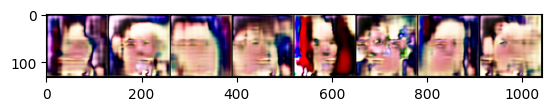

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 1.1218385696411133
Discriminator loss 54.226043701171875


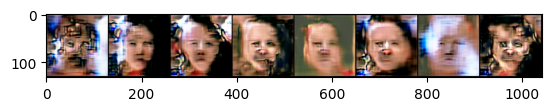

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 1.8479821681976318
Discriminator loss 49.445457458496094


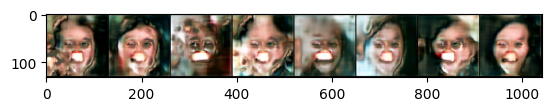

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 3.311462640762329
Discriminator loss 44.04615020751953


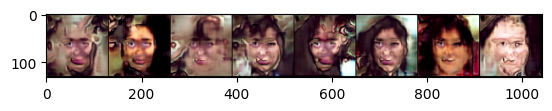

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 1.983883023262024
Discriminator loss 51.27955627441406


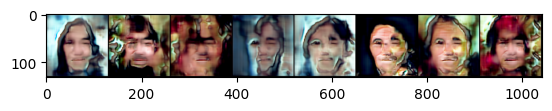

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 2.9271647930145264
Discriminator loss 39.33302307128906


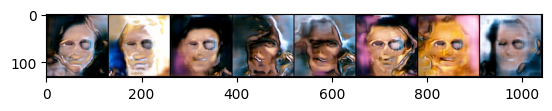

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 3.6159443855285645
Discriminator loss 41.96760940551758


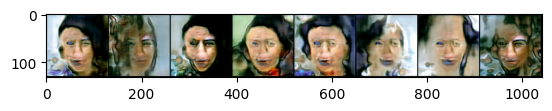

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 3.4858760833740234
Discriminator loss 37.03340530395508


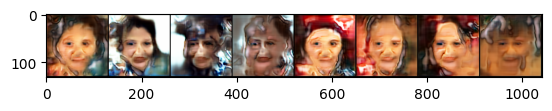

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 1.7621784210205078
Discriminator loss 38.84157180786133


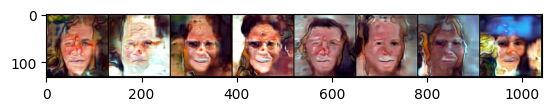

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 3.4760217666625977
Discriminator loss 34.437808990478516


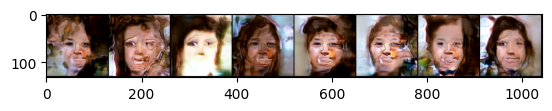

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 2.2549333572387695
Discriminator loss 35.82500076293945


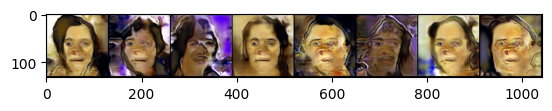

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 3.0950613021850586
Discriminator loss 37.025142669677734


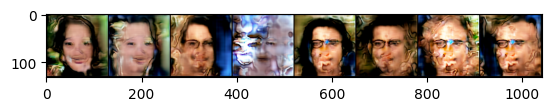

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generator loss 1.3326680660247803
Discriminator loss 32.774444580078125


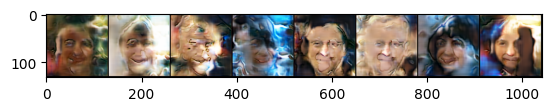

KeyboardInterrupt: 

In [11]:
G = Generator(c).to(device)
D = Discriminator(dc).to(device)

optimiser_G = torch.optim.Adam(G.parameters())
optimiser_D = torch.optim.Adam(D.parameters())

# training loop, you will want to train for more than 10 here!
epoch = 0
while (epoch<1000):
    
    # array(s) for the performance measures
    loss_arr_G = np.zeros(0)
    loss_arr_D = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):

        # sample real image from the dataset
        img,t = next(train_iterator)
        img,t = img.to(device), t.to(device)
        
        # generate x and crop parameters
        x = generateNoise()
        # Randomly choose on number from a range of 4 -> from [0, 1, 2, 3]
        # This should be the same choice used for crop16 and the crop for the input image
        choice = random.choice(range(4))

        # do the forward pass for the discriminator
        loss_D = discriminator_loss(img, x, choice, r)

        # backpropagate to compute the gradient of the loss w.r.t the parameters and optimise
        optimiser_D.zero_grad()
        loss_D.backward()
        optimiser_D.step()
        
        # do same for generator
        x = generateNoise()
        loss_G = generator_loss(x, choice)
        
        optimiser_G.zero_grad()
        loss_G.backward()
        optimiser_G.step()

        # collect stats
        loss_arr_G = np.append(loss_arr_G, loss_G.item())
        loss_arr_D = np.append(loss_arr_D, loss_D.item())

    # sample your model (autoencoders are not good at this)
    x = generateNoise()
    g = G(x)

    # plot some examples
    print('Generator loss ' + str(loss_G.mean().item()))
    print('Discriminator loss ' + str(loss_D.mean().item()))
    plt.rcParams['figure.dpi'] = 100
    plt.grid(False)
    plt.imshow(torchvision.utils.make_grid(g[:8]).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
    plt.show()
    plt.pause(0.0001)
    
    save(G, D, optimiser_G, optimiser_D, epoch, str(epoch))

    epoch = epoch+1

In [ ]:
# now show a batch of data for the submission, right click and save the image for your report
plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(batch_size))
z = generateNoise()

z0 = z[0:col_size].repeat(col_size,1,1,1) # z for top row
z1 = z[batch_size-col_size:].repeat(col_size,1,1,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(batch_size,1,1,1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = G(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().data.permute(0,2,1).contiguous().permute(2,1,0), cmap=plt.cm.binary)
plt.show()

In [ ]:
# optional example to resume training later
# params = torch.load('drive/My Drive/training/save.chkpt')
# A.load_state_dict(params['A'])
# optimiser.load_state_dict(params['optimiser'])
# epoch = params['epoch']